In [2]:
%reload_ext autoreload
%autoreload 2

In [3]:
from fastai import *
from fastai.vision import *
import torch
from torch import nn
from dsin.ae.data_manager.data_loader import (
    SideinformationImageImageList, ImageSiTuple)
from dsin.ae import config
from dsin.ae.si_ae import SideInformationAutoEncoder
from dsin.ae.si_net import SiNetChannelIn
from dsin.ae.loss_man import LossManager
from dsin.ae.distortions import Distortions
from dsin.ae.kitti_normalizer import ChangeImageStatsToKitti, ChangeState
from dsin.ae import config


In [4]:
class AverageMetric(Callback):
    "Wrap a `func` in a callback for metrics computation."
    def __init__(self, func):
        # If it's a partial, use func.func
        name = getattr(func,'func',func).__name__
        self.func, self.name = func, name

    def on_epoch_begin(self, **kwargs):
        "Set the inner value to 0."
        self.val, self.count = 0.,0

    def on_batch_end(self, last_output, last_target, **kwargs):
        "Update metric computation with `last_output` and `last_target`."
        if not is_listy(last_target): last_target=[last_target]
        self.count += last_target[0].size(0) # batch size
        X_DEC_IND =1
        val = self.func(last_output[X_DEC_IND], last_target[0])
        self.val += last_target[0].size(0) * val.detach().cpu()

    def on_epoch_end(self, last_metrics, **kwargs):
        "Set the final result in `last_metrics`."
        return add_metrics(last_metrics, self.val/self.count)

In [5]:
# config.use_si_flag = SiNetChannelIn.WithSideInformation
config.use_si_flag

<SiNetChannelIn.NoSideInformation: 3>

In [6]:
torch.__version__

'1.5.1'

In [7]:
si_autoencoder = SideInformationAutoEncoder(config.use_si_flag)


In [8]:
ls ../src/dsin

ae/  data/  dev_nb/  version.py


In [9]:
image_list = SideinformationImageImageList.from_csv(path="../src/dsin/data",csv_names=["tiny_KITTI_stereo_train.txt","tiny_KITTI_stereo_val.txt"])

In [10]:
image_list.items[0]

'../src/dsin/data/data_scene_flow_multiview/training/image_3/000000_10.png'

In [11]:
ll = image_list.split_by_valid_func(lambda x: 'testing'  in x ).label_from_func(lambda x: x)

In [12]:
batchsize = 1
data = (image_list
        .split_by_valid_func(lambda x: 'testing'  in x )
        .label_from_func(lambda x: x)
        .transform(None,size=(336,1224),resize_method=ResizeMethod.CROP,tfm_y=True)
        .databunch(bs=batchsize))
 

In [13]:
my_learner = Learner(data=data,
                     model=si_autoencoder,
                     opt_func=torch.optim.Adam,
                     loss_func=LossManager(config.use_si_flag),
                     metrics=[AverageMetric(Distortions._calc_dist)])

In [13]:
 my_learner.fit(1)


epoch,train_loss,valid_loss,_calc_dist,time
0,763.206909,747.609436,0.350852,12:10


In [14]:
datum =my_learner.data.train_ds[0][0]
# my_learner.predict(datum)


In [15]:



my_learner.predict(datum)


(Image (3, 336, 1224),
 tensor([[[170.7755, 189.9985, 153.2779,  ...,  76.8806, 109.1588,  83.4764],
          [120.7988, 166.7073, 218.3784,  ...,  69.2204,  84.6389,  88.1434],
          [129.0895, 128.8070, 140.6908,  ...,  80.7895,  81.9218,  76.1190],
          ...,
          [ 63.5510,  67.9412,  54.0680,  ...,  81.3354,  83.8514,  90.2500],
          [111.0412,  81.3289, 113.2457,  ...,  82.2373,  98.6264,  73.6944],
          [ 72.4129,  99.6358,  75.9784,  ..., 100.6821,  98.9401,  74.4957]],
 
         [[155.4836, 141.0759,  98.7477,  ...,  82.3681,  84.0746,  90.0142],
          [160.4725, 172.4418, 187.9760,  ...,  78.6329,  79.2082,  95.1359],
          [138.8332, 137.6268, 182.0879,  ...,  81.1103, 108.2783,  93.0124],
          ...,
          [ 69.3072,  72.4423,  86.4903,  ...,  85.1235,  93.6425, 101.3664],
          [105.0994, 102.5591,  95.2843,  ...,  95.2573,  74.9581,  96.9021],
          [ 85.5919,  82.4508,  90.6226,  ...,  87.4942, 109.6906,  89.0087]],
 
     

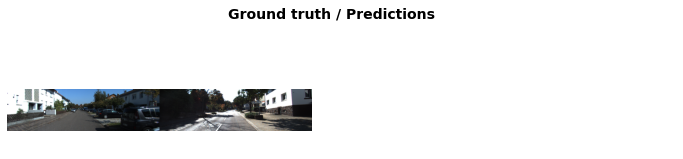

In [18]:
my_learner.show_results()

In [16]:
my_learner.save('tiny-1')


In [15]:
my_learner.load('tiny-1')


Learner(data=ImageDataBunch;

Train: LabelList (50 items)
x: SideinformationImageImageList
ImageSiTuple [tensor([[[0.0237, 0.0235, 0.0235,  ..., 0.3647, 0.3647, 0.3647],
         [0.0286, 0.0237, 0.0237,  ..., 0.3647, 0.3651, 0.3649],
         [0.0510, 0.0275, 0.0275,  ..., 0.3649, 0.3723, 0.3684],
         ...,
         [0.0980, 0.0904, 0.0865,  ..., 0.0786, 0.0786, 0.0786],
         [0.0980, 0.0902, 0.0825,  ..., 0.0784, 0.0784, 0.0784],
         [0.0980, 0.0864, 0.0861,  ..., 0.0747, 0.0747, 0.0747]],

        [[0.0357, 0.0353, 0.0314,  ..., 0.4084, 0.4086, 0.4123],
         [0.0433, 0.0355, 0.0314,  ..., 0.4190, 0.4231, 0.4233],
         [0.0481, 0.0396, 0.0316,  ..., 0.4074, 0.4151, 0.4190],
         ...,
         [0.1096, 0.1098, 0.1098,  ..., 0.0941, 0.0943, 0.0943],
         [0.1098, 0.1061, 0.1061,  ..., 0.0829, 0.0829, 0.0866],
         [0.1098, 0.1059, 0.1059,  ..., 0.0861, 0.0824, 0.0825]],

        [[0.0308, 0.0310, 0.0273,  ..., 0.4654, 0.4656, 0.4624],
         [0.0196, 

In [14]:
# # my_learner.fit_one_cycle(10)
# # my_learner.lr_find()
# # my_learner.save('stage-1')
# # my_learner.recorder.plot()
# # my_learner.load('stage-1')
# # my_learner.save("trained_model-stage1", return_path=True)
# # my_learner.export("trained_model_ex_stage1.pkl")